In [ ]:
#####################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
##############################################################################################################
# Quantitatively Compare 2 methods (LFTD, OP+A) for calculating joint angles 
# by calculating jerkiness over all VIDs
##############################################################################################################
# For each method:
# (1) calculate joint angles
# (2) evaluate jerkiness (calculate jerkiness sum I = ... for each angle), before filtering/smoothing
##############################################################################################################

from evalutils import calculate_norm_jerk
from geoutils import radToDeg, xyz_to_angles # my custom set of functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geo import *
import time
import glob

FPS = 50.            # BEFORE UPSAMPLING
dt = 1./FPS

N_JOINT_ANGLES = 12
angles_names = [
    "HeadPitch", "HeadYaw", 
    "LShoulderRoll", "LShoulderPitch", "LElbowRoll", "LElbowYaw",
    "RShoulderRoll", "RShoulderPitch", "RElbowRoll", "RElbowYaw", 
    "HipRoll", "HipPitch"
]
methods = [ 'OP+A', 'LFTD' ] 

# Overall jerkiness over all VIDs (summed)
normJerkMatrix = {}
for m in methods:
    normJerkMatrix[m] = []

for path in sorted(glob.glob('./../Dataset/ImgSeq/*')):
    
    VID = path.split('/')[-1]
    NUM_FRAMES = len(glob.glob(path + '/*'))
    print "Processing ", VID, "with ", NUM_FRAMES, " frames"
    
    joint_angles = {} # for each method, array of 12 joint angles for each frame, for a given VID
    I = {}            # for each method, array of I's (total jerkiness for each joint angle) for a given VID
    for m in methods:
        joint_angles[m] = np.zeros((NUM_FRAMES, N_JOINT_ANGLES)) # or init with nan ?
        I[m] = np.zeros(N_JOINT_ANGLES)

    ##############################################################################################################
    # Method 'OP+A' = OpenPose + domain-specific Assumptions
    ##############################################################################################################
    m = 'OP+A'

    jointID = {     # Mapping: joint names -> position in array as extracted
        #'Pelvis'    : NA,  # not available => have to estimate from hips
        'RHip'      : 8,    
        'LHip'      : 11,   
        #'Spine'     : NA,  # not available, not used
        'Neck'      : 1,
        #'Nose'      : NA,  # not available => have to estimate HeadYaw another way
        'HeadTop'   : 0,  
        'LShoulder' : 5,
        'LElbow'    : 6,
        'LWrist'    : 7,
        'RShoulder' : 2,
        'RElbow'    : 3,
        'RWrist'    : 4
    }

    data = np.load('./../Dataset/OpenPoseConstraintsFeatures/' +VID+ '.npz')['joints_3D'].astype(float)

    if len(data) != NUM_FRAMES:
        raise ValueError("#frames does not agree! -- method: " + m)

    st = time.time()
    for frame_num, xyz in enumerate(data): # iterate over frames

        ####################################################################
        # Calculate 12 joint angles, if not possible for this method set NAN (np.nan)
        # xyz[jointID['Pelvis']] gives xyz coordinates of Pelvis joint

        # For OP+A, pass None for Nose position => can only estimate HeadYaw
        # And estimate Pelvis position as midpoint of LHip-RHip
        PE = Point(xyz[jointID['LHip']]).midpoint_to(Point(xyz[jointID['RHip']]))

        try:
            joint_angles[m][frame_num] = xyz_to_angles(Point(xyz[jointID['HeadTop']]), None, 
                                                       Point(xyz[jointID['Neck']]),    PE, 
                        Point(xyz[jointID['LShoulder']]), Point(xyz[jointID['LElbow']]), Point(xyz[jointID['LWrist']]), 
                        Point(xyz[jointID['RShoulder']]), Point(xyz[jointID['RElbow']]), Point(xyz[jointID['RWrist']])                  
            )
        except ValueError as er:
            if str(er) == "Degenerate points in Plane()":
                joint_angles[m][frame_num] = joint_angles[m][frame_num-1]
            else:
                raise er

    print "\tTime of per frame calculations: (method = ", m,") \t", 1000000.*(time.time()-st)/NUM_FRAMES, "microsec"

    ##############################################################################################################
    # Method 'LFTD' = Lifting from the Deep: Convolutional 3D Pose Estimation from a Single Image
    # 
    #   From authors of "Lifting from the Deep", namely, Denis Tome, 
    #   The approach handles missing joints and try to always reconstruct the 3D pose using only the joints that 
    #   are visible. In that case the upper body should not be affected, whereas the lower body will be a mean 
    #   pose coming from the dataset.
    ##############################################################################################################
    m = 'LFTD'
    jointID = {     # Mapping: joint names -> position in array as extracted
        'Pelvis'    : 0,
        #'RHip'      : 1,   # not used
        #'LHip'      : 2,   # not used
        #'Spine'     : 7,   # not used
        'Neck'      : 8,
        'Nose'      : 9,
        'HeadTop'   : 10,  
        'LShoulder' : 11,
        'LElbow'    : 12,
        'LWrist'    : 13,
        'RShoulder' : 14,
        'RElbow'    : 15,
        'RWrist'    : 16
    }

    data = np.load('./../Dataset/LiftFromDeep/' +VID+ '.npz')['joints_3D'].astype(float)
    if len(data) != NUM_FRAMES:
        raise ValueError("#frames does not agree! -- method: " + m)

    st = time.time()
    for frame_num, xyz in enumerate(data): # iterate over frames

        ####################################################################
        # Calculate 12 joint angles, if not possible for this method set NAN (np.nan)
        # xyz[jointID['Pelvis']] gives xyz coordinates of Pelvis joint

        joint_angles[m][frame_num] = xyz_to_angles(Point(xyz[jointID['HeadTop']]), Point(xyz[jointID['Nose']]), 
                                                   Point(xyz[jointID['Neck']]),    Point(xyz[jointID['Pelvis']]), 
                    Point(xyz[jointID['LShoulder']]), Point(xyz[jointID['LElbow']]), Point(xyz[jointID['LWrist']]), 
                    Point(xyz[jointID['RShoulder']]), Point(xyz[jointID['RElbow']]), Point(xyz[jointID['RWrist']])                  
        )


    print "\tTime of per frame calculations: (method = ", m,") \t", 1000000.*(time.time()-st)/NUM_FRAMES, "microsec"


    ##############################################################################################################
    ##############################################################################################################
    # For each method: Calculate jerkiness for each joint angle separately, over all frames

    for m in methods:
        normJerkMatrix[m].append( calculate_norm_jerk( joint_angles[m], fr=FPS ) ) # 50 Hz ! before upsampling


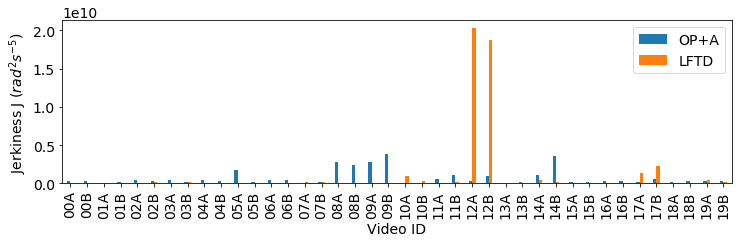

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 26
 27 28 29 30 31 32 33 34 35 36 37 38 39]
	0.552631578947 8.30743359989e-06
	 samples A and B are significantly different


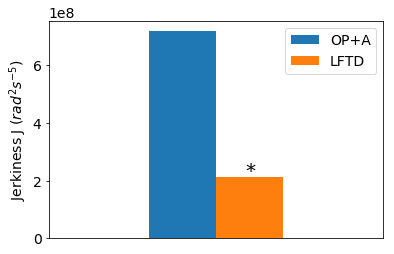

	0.289473684211 0.0667482436107
	 samples A and B are NOT significantly different
	0.763157894737 1.09201974615e-10
	 samples A and B are significantly different
	0.815789473684 3.74851778121e-12
	 samples A and B are significantly different
	0.368421052632 0.00811379698258
	 samples A and B are NOT significantly different
	0.315789473684 0.0349770013068
	 samples A and B are NOT significantly different
	0.605263157895 7.00801259222e-07
	 samples A and B are significantly different
	0.789473684211 2.08088521427e-11
	 samples A and B are significantly different
	0.421052631579 0.00150327594353
	 samples A and B are NOT significantly different
	0.394736842105 0.00359198509027
	 samples A and B are NOT significantly different
	0.657894736842 4.72169728717e-08
	 samples A and B are significantly different
	0.842105263158 6.38358792094e-13
	 samples A and B are significantly different


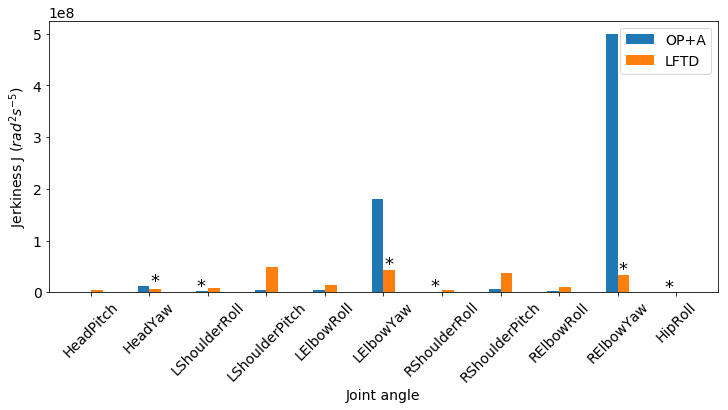

* denotes significantly better performance


In [56]:
############################################################
# FINAL FIGURES - comparing angular jerkiness
############################################################
# SUMMED BY ANGLES
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

xaxis = np.arange(40)
xaxis_labels = []
for i, x in enumerate(xaxis):
    if i % 2 == 0:
        t = 'A'
    else:
        t = 'B'
    xaxis_labels.append( '{:02d}{:}'.format(int(x/2), t)  )
w = 0.2 # bar width
plt.figure(figsize=(12,3))

mat = np.array(normJerkMatrix['OP+A'])[:,:11]
totalJerkPerVID = np.sum( mat, axis=1 )
plt.bar(xaxis-w, totalJerkPerVID, width=w, align='edge', label='OP+A')#, color=clrs[i])

mat = np.array(normJerkMatrix['LFTD'])[:,:11]
totalJerkPerVID = np.sum( mat, axis=1 )
plt.bar(xaxis, totalJerkPerVID, width=w, align='edge', label='LFTD')#, color=clrs[i])
    
plt.xticks(xaxis, xaxis_labels, rotation=90)
plt.ylabel('Jerkiness J ($rad^{2}s^{-5}$)')
plt.xlabel('Video ID')
plt.xlim(-0.5, 39.5)
plt.legend()
plt.show()

########################################################################################################################
# Overall: SUMMED BY ANGLES, AVG OVER VIDEOS
# from evalutils import stat_sig_plot
from evalutils import statistical_significance
def stat_sig_plot(dataA, dataB, y_label, data_labels, markHigher, show=True, showErr=True):
    
    meanA = np.mean(dataA)
    meanB = np.mean(dataB)
    stdA = np.std(dataA)
    stdB = np.std(dataB)
    ss = statistical_significance(dataA, dataB, 0.001, False)
    
    plt.figure()
    w = 0.2 # bar width  
    ylim_max = 0.5
    if showErr:
        plt.bar(0.-w/2., meanA, yerr=stdA, width=w, align='center', label=data_labels[0])      # bar A
        plt.bar(0.,      meanB, yerr=stdB, width=w, align='edge', label=data_labels[1])        # bar B
    else:
        plt.bar(0.-w/2., meanA, width=w, align='center', label=data_labels[0])      # bar A
        plt.bar(0.,      meanB, width=w, align='edge', label=data_labels[1])        # bar B
    ax = plt.gca()
    p = ax.patches
    if ss:
        if (meanA > meanB and markHigher) or (meanA <= meanB and not markHigher):
            # mark bar A
            i = 0
        else:
            # mark bar B
            i = 1
        ax.text(p[i].get_x()+w/2.3, p[i].get_height(), '*', fontsize=20)#, color='dimgrey')
    plt.ylabel(y_label) #, fontsize=14)

    ax.set_xticks([])
    plt.xlim(-ylim_max, ylim_max)
    #plt.ylim(0, 18*10**8)             # if errorbars are used
    plt.legend()
    if show:
        plt.show()

# REMOVE 12A, 12B
keepVideos = np.array(
    np.arange(12*2).tolist() + range(26, 40)
)
print keepVideos

mat = np.array(normJerkMatrix['OP+A'])[keepVideos,:11]
totalJerkPerVID_OP = np.sum( mat, axis=1 )
# print totalJerkPerVID_OP
mat = np.array(normJerkMatrix['LFTD'])[keepVideos,:11]
totalJerkPerVID_LF = np.sum( mat, axis=1 )

data_labels = ['OP+A', 'LFTD']
stat_sig_plot(totalJerkPerVID_OP, totalJerkPerVID_LF, 'Jerkiness J ($rad^{2}s^{-5}$)', data_labels, 
              markHigher=False, show=True, 
              #showErr=True,
              showErr=False
             )


########################################################################################################################
# By angles

mat_OP = np.array(normJerkMatrix['OP+A'])[keepVideos,:11]
mat_LF = np.array(normJerkMatrix['LFTD'])[keepVideos,:11]

# for i in range(11):
#     ss = statistical_significance(mat_OP[:, i], mat_LF[:, i], 0.05, False)
#     print angles_names[i], ss, "OP+A = ", np.mean(mat_OP[:, i]), "LFTD = ", np.mean(mat_LF[:, i])

xaxis = np.arange(11)
w = 0.2 # bar width
plt.figure(figsize=(12,5))

plt.bar(xaxis-w, np.mean(mat_OP, axis=0), 
        #yerr=np.std(mat_OP, axis=0), 
        width=w, align='edge', label='OP+A')#, color=clrs[i])

mat = np.array(normJerkMatrix['LFTD'])[:,:11]
totalJerkPerVID = np.sum( mat, axis=1 )
plt.bar(xaxis, np.mean(mat_LF, axis=0), 
        #yerr=np.std(mat_LF, axis=0), 
        width=w, align='edge', label='LFTD')#, color=clrs[i])

ax = plt.gca()
p = ax.patches    
for i in range(11):
    ss = statistical_significance(mat_OP[:, i], mat_LF[:, i], 0.001, False)
    if ss: # is stat sig => put asterisk
        of = 0
        if i == 5:
            of = 1.37*10**8
        if i == 9:
            of = 4.65*10**8
        if np.mean(mat_OP[:, i]) > np.mean(mat_LF[:, i]): # LFTD is better => put asterisk on it
            ax.text(p[i].get_x()+w/0.9, p[i].get_height()-of, '*', fontsize=18)
        else:
            ax.text(p[i].get_x(), p[i].get_height()-of, '*', fontsize=18)
        
    
plt.xticks(xaxis, angles_names[:11], rotation=45)
plt.ylabel('Jerkiness J ($rad^{2}s^{-5}$)')
plt.xlabel('Joint angle')
plt.legend()
plt.show()

print '* denotes significantly better performance'
